In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_columns = 1000      # set column display
pd.options.display.max_rows = 1000         # set row display
pd.options.mode.chained_assignment = None  # default='warn'

data2019 = pd.read_csv('../data/tables/2019_merged.csv')
data2020 = pd.read_csv('../data/tables/2020_merged.csv')

hexes = gpd.read_file('../data/shapefiles/nyc/hexagons.geojson')

In [2]:
def determine_phase(row):
    if row['month'] <= 2:
        return 'precovid' 
    elif row['month'] == 3 & row['day'] <= 17:
        return 'phase_1' 
    else:
        return 'phase_2'
    
def determine_weekday(row):
    weekend = ['Saturday', 'Sunday']
    return 1 if row['weekday'] in weekend else 0

In [3]:
keep_cols = [
    'hex_id_8', 'month', 'day', 'year', 'night?', 'weekday', 
    'mta_inflow_counts', 'mta_outflow_counts',
    'citi_inflow_counts', 'citi_outflow_counts',
]

filtered_2019 = data2019[keep_cols]
filtered_2020 = data2020[keep_cols]

filtered_2019['year'] = 2019
filtered_2020['year'] = 2020

combined = filtered_2019.append(filtered_2020)\
                        .sort_values(by=['hex_id_8', 'month', 'day', 'night?', 'year'])\
                        .reset_index(drop=True)

combined['phase']    = combined.apply(lambda x: determine_phase(x),   axis=1)
combined['weekday?'] = combined.apply(lambda x: determine_weekday(x), axis=1)

combined.head()

,hex_id_8,month,day,year,night?,weekday,mta_inflow_counts,mta_outflow_counts,citi_inflow_counts,citi_outflow_counts,phase,weekday?
0,882a100005fffff,1,1,2019,0,Tuesday,0.0,0.0,0.0,0.0,precovid,0
1,882a100005fffff,1,1,2020,0,Wednesday,0.0,0.0,0.0,0.0,precovid,0
2,882a100005fffff,1,1,2019,1,Tuesday,0.0,0.0,0.0,0.0,precovid,0
3,882a100005fffff,1,1,2020,1,Wednesday,0.0,0.0,0.0,0.0,precovid,0
4,882a100005fffff,1,2,2019,0,Wednesday,0.0,0.0,0.0,0.0,precovid,0


In [4]:
hexes_by_phase = combined.drop(['month', 'day'], axis=1)\
                         .groupby(['hex_id_8', 'phase', 'weekday?', 'night?', 'year'])\
                         .sum()\
                         .reset_index()

# get only counts columns
sel_cols = hexes_by_phase.columns[5:]

# get difference year over year as new DF, rename columns and recombine
combined_diff = hexes_by_phase[sel_cols].shift(1, axis=0) 
combined_diff.columns = ['2019_' + col for col in combined_diff.columns]
result = pd.concat([hexes_by_phase, combined_diff],
                   axis=1)

# filter results for only year 2020
results_2020 = result[result['year'] == 2020]
results_2020.tail(5)

,hex_id_8,phase,weekday?,night?,year,mta_inflow_counts,mta_outflow_counts,citi_inflow_counts,citi_outflow_counts,2019_mta_inflow_counts,2019_mta_outflow_counts,2019_citi_inflow_counts,2019_citi_outflow_counts
28767,882a10776dfffff,phase_2,1,1,2020,0.0,0.0,26.0,48.0,0.0,0.0,92.0,125.0
28769,882a10776dfffff,precovid,0,0,2020,0.0,0.0,1420.0,1381.0,0.0,0.0,1330.0,1298.0
28771,882a10776dfffff,precovid,0,1,2020,0.0,0.0,254.0,163.0,0.0,0.0,191.0,136.0
28773,882a10776dfffff,precovid,1,0,2020,0.0,0.0,773.0,679.0,0.0,0.0,449.0,476.0
28775,882a10776dfffff,precovid,1,1,2020,0.0,0.0,101.0,71.0,0.0,0.0,65.0,37.0


In [5]:
# calculate pct delta (new-old)/old*100
results_2020['mta_inflow_pct_delta']   = (results_2020['mta_inflow_counts'] - results_2020['2019_mta_inflow_counts'])/\
                                          results_2020['2019_mta_inflow_counts'] * 100
results_2020['mta_outflow_pct_delta']  = (results_2020['mta_outflow_counts'] - results_2020['2019_mta_outflow_counts'])/\
                                          results_2020['2019_mta_outflow_counts'] * 100
results_2020['citi_inflow_pct_delta']  = (results_2020['citi_inflow_counts'] - results_2020['2019_citi_inflow_counts'])/\
                                          results_2020['2019_citi_inflow_counts'] * 100
results_2020['citi_outflow_pct_delta'] = (results_2020['citi_outflow_counts'] - results_2020['2019_citi_outflow_counts'])/\
                                          results_2020['2019_citi_outflow_counts'] * 100

drop_cols = [
    'year',
    'mta_inflow_counts', 'mta_outflow_counts',
    'citi_inflow_counts', 'citi_outflow_counts',
    '2019_mta_inflow_counts', '2019_mta_outflow_counts',
    '2019_citi_inflow_counts', '2019_citi_outflow_counts'
]

results_2020 = results_2020.drop(drop_cols, axis=1)
results_2020.tail(5)

,hex_id_8,phase,weekday?,night?,mta_inflow_pct_delta,mta_outflow_pct_delta,citi_inflow_pct_delta,citi_outflow_pct_delta
28767,882a10776dfffff,phase_2,1,1,NaN,NaN,-71.739130,-61.600000
28769,882a10776dfffff,precovid,0,0,NaN,NaN,6.766917,6.394453
28771,882a10776dfffff,precovid,0,1,NaN,NaN,32.984293,19.852941
28773,882a10776dfffff,precovid,1,0,NaN,NaN,72.160356,42.647059
28775,882a10776dfffff,precovid,1,1,NaN,NaN,55.384615,91.891892


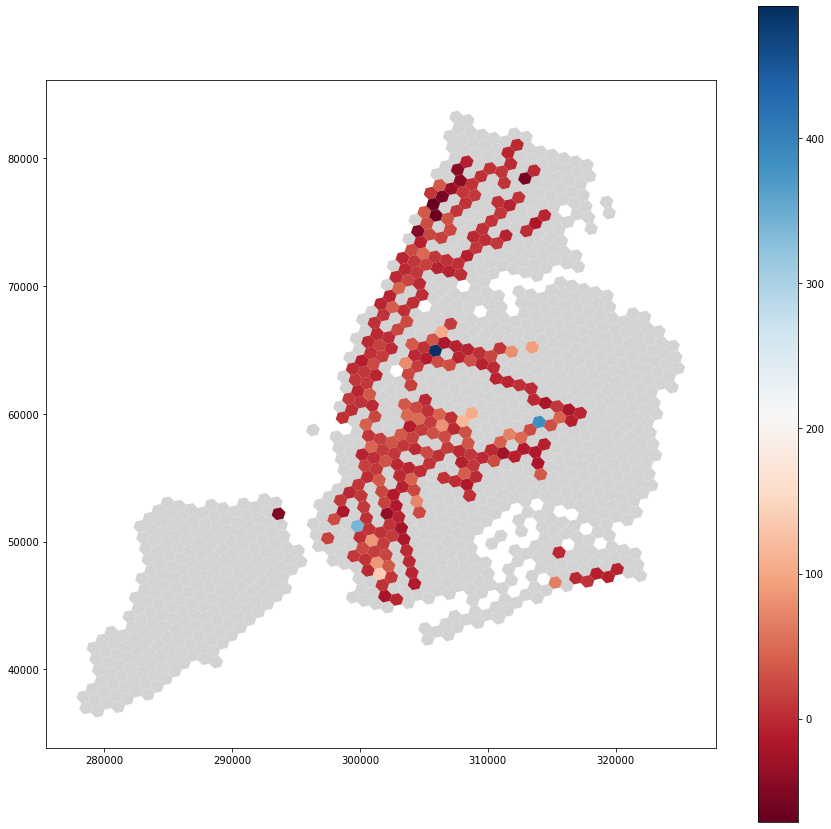

In [6]:
precovid_weekend_nights = results_2020[(results_2020['phase'] == 'precovid') &\
                                       (results_2020['weekday?'] == 1) &\
                                       (results_2020['night?'] == 1)]

phase1_weekend_nights = results_2020[(results_2020['phase'] == 'phase_1') &\
                                     (results_2020['weekday?'] == 1) &\
                                     (results_2020['night?'] == 1)]

phase2_weekend_nights = results_2020[(results_2020['phase'] == 'phase_2') &\
                                     (results_2020['weekday?'] == 1) &\
                                     (results_2020['night?'] == 1)]


gdf = hexes.merge(precovid_weekend_nights)
feat = 'mta_inflow_pct_delta'

gdf = gdf.replace([np.inf, -np.inf], np.nan) # replace inf values with NaN
gdf = gdf[~(gdf[feat].isna())] # drop NaN values for feature

base = hexes.plot(color='lightgrey',
                 figsize=(15,15))
gdf.plot(ax = base,
         column=feat,
         legend=True,
         cmap='RdBu');

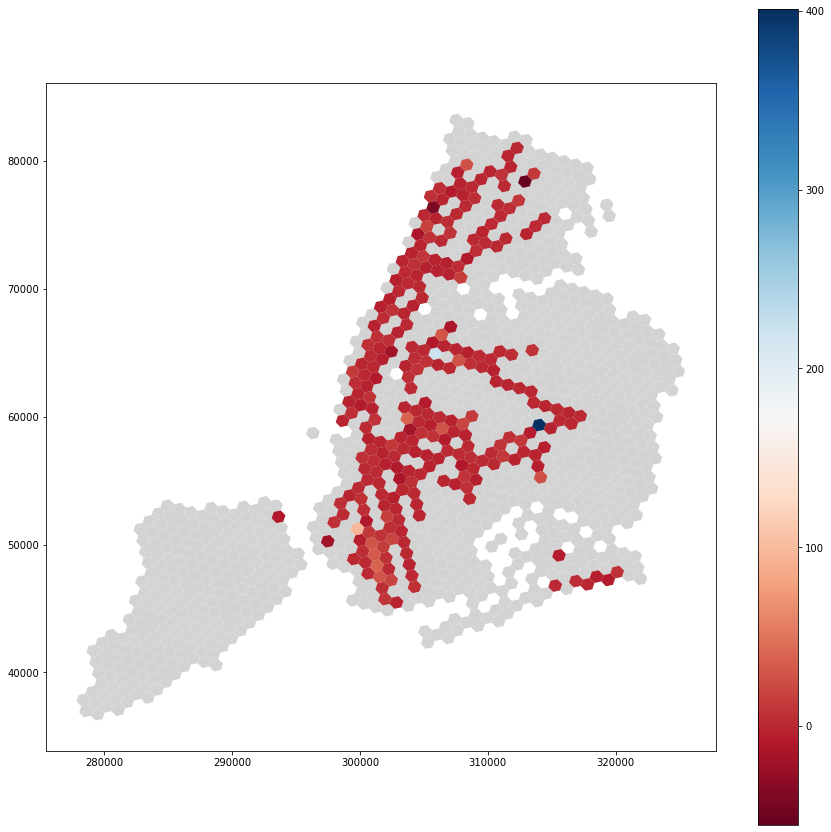

In [7]:
precovid_weekday_days = results_2020[(results_2020['phase'] == 'precovid') &\
                                       (results_2020['weekday?'] == 0) &\
                                       (results_2020['night?'] == 0)]

phase1_weekday_days = results_2020[(results_2020['phase'] == 'phase_1') &\
                                     (results_2020['weekday?'] == 0) &\
                                     (results_2020['night?'] == 0)]

phase2_weekday_days = results_2020[(results_2020['phase'] == 'phase_2') &\
                                     (results_2020['weekday?'] == 0) &\
                                     (results_2020['night?'] == 0)]


gdf = hexes.merge(precovid_weekday_days)
feat = 'mta_inflow_pct_delta'

gdf = gdf.replace([np.inf, -np.inf], np.nan) # replace inf values with NaN
gdf = gdf[~(gdf[feat].isna())] # drop NaN values for feature

base = hexes.plot(color='lightgrey',
                 figsize=(15,15))

gdf.plot(ax = base,
         column=feat,
         legend=True,
         cmap='RdBu');

Data for 2019 and 2020 by hex:
* Independent:
    * Study period (pre-COVID, phase 1, phase 2, phase 3)
    * Year (2019/2020)
    * Hex ID
    * Day/Night
* Dependent:
    * MTA Inflow (summed to study period)
    * MTA Outflow (summed to study period)
    * Citibike Inflow (summed to study period)
    * Citibike Outflow (summed to study period)